# Stability analysis

# Computing the Jacobian Matrix at the Equilibrium Point 

In [71]:
using ForwardDiff
using LinearAlgebra
using PyCall
using PyPlot
include("AerodynamicsModel.jl")
include("Params.jl")
include("SphereConeVehicleModel.jl")

entry_vehicle_simplified_dynamics (generic function with 1 method)

## Parameters

In [79]:
params = Dict("r_min" => 0.001, # smallest radius of the cone [m]
              "r_max" => 1.30, # largest radius of the cone [m]
              "δ" => 45 / 360 * 2 * pi, # opening angle of the cone [rad]
              "m" => 569.7, # mass of the Phoenix entry system [kg]
              "x_g" => -0.150, # axial center-of-gravity location [m]
              "c" => 1.20, # distance between the radial axis and the cluster of thrusters[m]
              "F_max" => 36.0, # maximum force applied by the thrusters [N]
              "Jxx" => 293.15, # Phoenix entry system [kg.m^2]
              "Jyy" => 184, # Phoenix entry system [kg.m^2]
              "Jzz" => 208.02, # Phoenix entry system [kg.m^2]
              "Jxy" => 0.451, # Phoenix entry system [kg.m^2]
              "Jxz" => -4.424, # Phoenix entry system [kg.m^2] 
              "Jyz" => 0.372, # Phoenix entry system [kg.m^2]
              "g" => 3.711, # Mars gravity [m^2.s^-1]
              "h" => 10800, # Atmospheric Scale Height [m]
              "ρ_0" => 0.020, # Surface density of Mars atmosphere [kg.m^-3]
              "r_p" => 3389.5e3, # Volumetric mean radius of Mars [m]
              "ω_p" => [0, 0, 7.088e-05]) # Angular velocity of Mars [rad.s^-1]
complete_params!(params);

## Equilibrium Point definition

In [80]:
# Iniitial altitude
x_0 = - 125000.0 - 3389.5e3

# Initial speed
v_0 = 5500 * [1, 0, 0]

# Initial orientation
q_0 = [1, 0, 0, 0]
# q_0 = [0.999, 0, 0, 0.04]
q_0 = q_0 / norm(q_0)
    
# Initial state
X_0 = [x_0, 0, 0, q_0[1], q_0[2], q_0[3], q_0[4], v_0[1], v_0[2], v_0[3], 0, 0, 0]

13-element Array{Float64,1}:
   -3.5145e6
    0.0     
    0.0     
    1.0     
    0.0     
    0.0     
    0.0     
 5500.0     
    0.0     
    0.0     
    0.0     
    0.0     
    0.0     

## Simplified Dynamics Model
- We assume flat planet model, gravity acceleration is directed along the x axis.
- We assume constant uniform of the atmosphere.
- We assume that the fluid is static.

## ForwardDiff Jacobian

In [81]:
function open_loop_entry_vehicle_simplified_dynamics(X::Vector)
    u = zeros(12,1)
    ẋ = X - X
    entry_vehicle_simplified_dynamics!(ẋ, X, u, params)
end

function forward_diff_jacobian(open_loop_entry_vehicle_simplified_dynamics, X_eq)
    A = ForwardDiff.jacobian(open_loop_entry_vehicle_simplified_dynamics, X_0)
    return A
end

function jacobian_eigenvalues(open_loop_entry_vehicle_simplified_dynamics, X_0, removed_indexes)
    A = forward_diff_jacobian(open_loop_entry_vehicle_simplified_dynamics, X_0)
    A_filtered = A[setdiff(1:end, removed_indexes), setdiff(1:end, removed_indexes)]
    eigenvalues = eigvals(A_filtered)
    return A, A_filtered, eigenvalues
end

removed_indexes = [1, 4, 8]
A, A_filtered, eigenvalues = jacobian_eigenvalues(open_loop_entry_vehicle_simplified_dynamics, X_0, removed_indexes)
eigenvalues

10-element Array{Complex{Float64},1}:
                     0.0 + 0.0im              
                     0.0 + 0.0im              
   1.5163176581012294e-7 + 49.73032010837139im
   1.5163176581012294e-7 - 49.73032010837139im
   1.5163177025101504e-7 + 49.73031462109581im
   1.5163177025101504e-7 - 49.73031462109581im
  -4.434989437077981e-16 + 0.0im              
     -0.5125699903925122 + 0.0im              
     -0.5125699903925128 + 0.0im              
 -1.3050957308954483e-18 + 0.0im              

In [82]:
eigvecs(A_filtered)[:, 7:8]

10×2 Array{Complex{Float64},2}:
     0.707205+0.0im     0.629348+0.0im
    -0.707008+0.0im    -0.629172+0.0im
  -5.07488e-7+0.0im  4.70227e-14+0.0im
 -2.85052e-20+0.0im  -2.93146e-5+0.0im
 -2.85132e-20+0.0im  -2.93228e-5+0.0im
 -3.13645e-16+0.0im    -0.322585+0.0im
  3.13557e-16+0.0im     0.322495+0.0im
   -9.013e-40+0.0im  6.98192e-22+0.0im
  1.99484e-24+0.0im   3.00516e-5+0.0im
  7.84265e-25+0.0im   3.00599e-5+0.0im

## Finite Difference Jacobian

In [83]:
function finite_difference_jacobian(open_loop_entry_vehicle_simplified_dynamics, X_eq, ψ)
    n = length(X_eq)
    jacobian = zeros((n,n))
    for i=1:n
        d_X = zeros(n)
        d_X[i] = ψ
        d_X_dot_plus = open_loop_entry_vehicle_simplified_dynamics(X_eq + d_X) 
        d_X_dot_minus = open_loop_entry_vehicle_simplified_dynamics(X_eq - d_X) 
        X_dot = (d_X_dot_plus - d_X_dot_minus) ./(2*ψ) 
        jacobian[:, i] = X_dot
    end
    return jacobian 
end

function finite_difference_jacobian_eigenvalues(open_loop_entry_vehicle_simplified_dynamics, X_0, ψ, removed_indexes)
    A = finite_difference_jacobian(open_loop_entry_vehicle_simplified_dynamics, X_0, ψ)
    A_filtered = A[setdiff(1:end, removed_indexes), setdiff(1:end, removed_indexes)]
    eigenvalues = eigvals(A_filtered)
    return A, eigenvalues
end

ψ = 1e-6
finite_difference_jacobian_eigenvalues(open_loop_entry_vehicle_simplified_dynamics, X_0, ψ, removed_indexes)[2]

10-element Array{Complex{Float64},1}:
                     0.0 + 0.0im               
                     0.0 + 0.0im               
    1.516322827299632e-7 + 49.730320108296716im
    1.516322827299632e-7 - 49.730320108296716im
   1.5163228539449847e-7 + 49.73031462102122im 
   1.5163228539449847e-7 - 49.73031462102122im 
     -0.5125699903935347 + 0.0im               
      -0.512569990393537 + 0.0im               
 -2.4128236393795028e-14 + 0.0im               
   2.168259135608778e-14 + 0.0im               

# Plot the maximum real part of eigenvalues 

In [112]:
function plot_eigenvalues(params, removed_indexes, num_nodes; display=true)
    δ_vect = range(10, stop=80, length=num_nodes) / 360 * 2 * pi
    num_x_g = 7
    x_g_vect = range(-0.4, stop=0.8, length=num_x_g)

    max_eig = zeros(num_nodes)
    for j=1:num_x_g
        x_g = x_g_vect[j]
        params["x_g"] = x_g
        for i=1:num_nodes
            δ = δ_vect[i]
            params["δ"] = δ
            complete_params!(params)
            A = forward_diff_jacobian(open_loop_entry_vehicle_simplified_dynamics, X_0)
            A_filtered = A[setdiff(1:end, removed_indexes), setdiff(1:end, removed_indexes)]
            max_eig[i] = max_eigenvalue(A_filtered)
    #         println("max_eig ", max_eig[i], "  delta  ", δ*(360/2/pi))
        end
        plot(δ_vect.*(360/2/pi), max_eig, color="blue", linewidth=2.0, linestyle="-", 
            label=string("x_g = ", string(x_g)), alpha=0.1*j)
        legend()
    end
    xlabel("δ")
    title("Max real part eigenvalue for a varying cone opening angle.")
    grid("on")
    ylim((-1, 1))
    if display 
        tight_layout()
        show()
    end
    return
end

function max_eigenvalue(A_filtered)
    real_parts = real.(eigvals(A_filtered))
    max_eig = -Inf
    ϵ = 1e-5
    for i=1:length(real_parts)
        if abs(real_parts[i]) > ϵ && real_parts[i] > max_eig
            max_eig = real_parts[i]
        end
    end
    return max_eig
end

max_eigenvalue (generic function with 1 method)

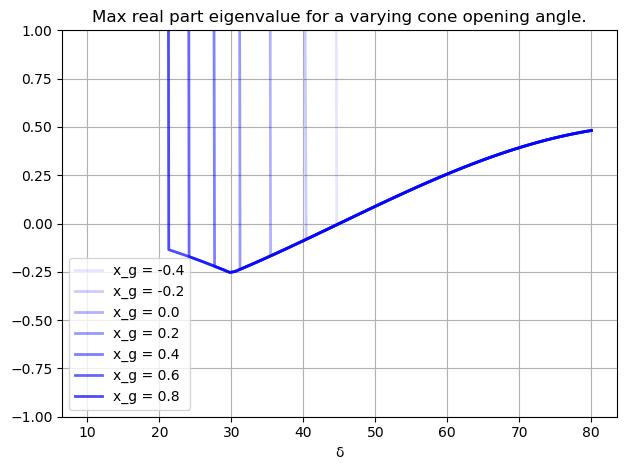

In [113]:
num_nodes = 100
removed_indexes = [1, 4, 8]
plot_eigenvalues(params, removed_indexes, num_nodes)

## Center of pressure and center of mass

In [64]:
function plot_center_of_pressure(params, num_nodes; display=true)
    r_max = params["r_max"]
    r_min = params["r_min"]
    l = params["l"]
    x_g = params["x_g"]

    α_vect = range(0.0001, stop=pi/2, length=num_nodes)
    C_F2_vect = zeros(num_nodes, 3)
    C_τ2_vect = zeros(num_nodes, 3)
    for i=1:num_nodes
        C_F2_vect[i, :], C_τ2_vect[i, :] = aerodynamics_coefficents(α_vect[i], r_max, r_min, l, x_g)
    end
    X_g = x_g .* ones(num_nodes)
    X_p = X_g + C_τ2_vect[:, 3] ./ C_F2_vect[:, 2]  
    plot(α_vect, X_g, color="blue", linewidth=2.0, linestyle="-", label="Center of mass")
    plot(α_vect, X_p, color="red", linewidth=2.0, linestyle="-", label="Center of pressure")
    legend()
    xlabel("α")
    title("Center of pressure and center of mass of the vehicle.")
    grid("on")
    if display 
        tight_layout()
        show()
    end
    return
end

num_nodes = 100
plot_center_of_pressure(params, num_nodes; display=true)

UndefVarError: UndefVarError: aerodynamics_coefficents not defined

## Plot angle \lambda of the aerodynamics force vector (wrt to the axis of the vehicle) for different alpha's
It allows us to check for the stability of the vehicle. 
If the angle lambda is below alpha for a given alpha then we are stable.
Otherwise we could have balancing effects.

In [65]:
function plot_aerodynamics_ceofficients(params, num_nodes; display=true)
    r_max = params["r_max"]
    r_min = params["r_min"]
    l = params["l"]
    x_g = params["x_g"]

    α = range(0, stop=pi/2, length=num_nodes)
    C_F2 = zeros(num_nodes, 3)
    C_τ2 = zeros(num_nodes, 3)
    λ = zeros(num_nodes)
    for i=1:num_nodes
        C_F2[i, :], C_τ2[i, :] = aerodynamics_coefficents(α[i], r_max, r_min, l, x_g)
        λ[i] = atan(1 * C_F2[i, 2] / C_F2[i, 1])
    end

    plot(α, α, color="blue", linewidth=2.0, linestyle="-", label="α")
    plot(α, λ, color="red", linewidth=2.0, linestyle="-", label="λ")
    legend()
    xlabel("α")
    title("Angle λ of the aerodynamics force vector (wrt to the axis of the vehicle).")
    grid("on")
    if display 
        tight_layout()
        show()
    end
    return
end

num_nodes = 100
plot_aerodynamics_ceofficients(params, num_nodes)

UndefVarError: UndefVarError: aerodynamics_coefficents not defined

## Plot aerodynamics coefficients

In [66]:
function plot_aerodynamics_ceofficients(r_max, r_min, l, x_g, num_nodes; display=true)
    r_max = params["r_max"]
    r_min = params["r_min"]
    l = params["l"]
    x_g = params["x_g"]
    
    α_vect = range(0, stop=pi/2, length=num_nodes)
    C_F2_vect = zeros(num_nodes, 3)
    C_τ2_vect = zeros(num_nodes, 3)
    for i=1:num_nodes
        C_F2_vect[i, :], C_τ2_vect[i, :] = aerodynamics_coefficents(α_vect[i], r_max, r_min, l, x_g)
    end
    plot(α_vect, C_F2_vect[:, 1], color="blue", linewidth=2.0, linestyle="-", label="C_X2_vehicle")
    plot(α_vect, C_F2_vect[:, 2], color="red", linewidth=2.0, linestyle="-", label="C_Y2_vehicle")
    plot(α_vect, C_τ2_vect[:, 3], color="green", linewidth=2.0, linestyle="-", label="C_n2_vehicle")
    plot(α_vect, C_F2_vect[:, 2] ./ tan.(α_vect), color="red", linewidth=2.0, linestyle=":", label="C_Y2_vehicle / tan(α)")
    plot(α_vect, C_τ2_vect[:, 3] ./ tan.(α_vect), color="green", linewidth=2.0, linestyle=":", label="C_n2_vehicle / tan(α)")
    legend()
    xlabel("α")
    title("Aerodynamics coefficients for the vehicle.")
    grid("on")
    if display 
        tight_layout()
        show()
    end
    return
end

num_nodes = 100
plot_aerodynamics_ceofficients(params, num_nodes; display=true)

UndefVarError: UndefVarError: aerodynamics_coefficents not defined